In [32]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("Courses.csv")

In [33]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("Courses.csv")

# 1. Remove specified columns
columns_to_remove = ['nplay_video', 'incomplete_flag', 'roles']
df_cleaned = df.drop(columns=columns_to_remove)

# 2. Handle missing values
# For categorical variables (LoE_DI) - impute with mode
df_cleaned['LoE_DI'] = df_cleaned['LoE_DI'].fillna(df_cleaned['LoE_DI'].mode()[0])

# For gender in random way
missing_indices = df_cleaned[df_cleaned['gender'].isnull()].index
df_cleaned.loc[missing_indices, 'gender'] = np.random.choice(df_cleaned['gender'].dropna(), len(missing_indices))

# For YoB - impute with median
df_cleaned['YoB'] = df_cleaned['YoB'].fillna(df_cleaned['YoB'].median())

# 3. Drop rows with missing grades
df_cleaned = df_cleaned.dropna(subset=['grade'])

# 5. Define function for nchapters imputation
def impute_nchapters_simple(df):
    # Create copy of original nchapters
    df['nchapters_imputed'] = df['nchapters'].copy()
    
    # Imputation logic based on certification and activity days
    mask = df['nchapters'].isna()
    
    conditions = [
        # Condition 1: Certified students
        (mask) & (df['certified'] == 1),
        # Condition 2: Not certified but active (ndays_act > 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] > 3),
        # Condition 3: Not certified and some activity (ndays_act <= 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] <= 3),
        # Condition 4: No activity recorded (ndays_act is NaN) but viewed course
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 1),
        # Condition 5: No activity and never viewed (complete non-engagement)
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 0)
    ]
    
    values = [
        16,  # Average for certified students
        3,   # Average for non-certified active students
        1,   # Minimal engagement
        1,   # Viewed but no sustained activity
        0    # Never engaged with content
    ]
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Apply imputation
    df['nchapters_imputed'] = np.select(conditions, values, df['nchapters_imputed'])
    
    return df['nchapters_imputed']

# Apply nchapters imputation
df_cleaned['nchapters_imputed'] = impute_nchapters_simple(df_cleaned)

# 6. nevents missing data
def impute_nevents(row):
    if pd.isna(row['nevents']):  # Only impute if the value is missing
        if row['nchapters'] == 0:
            return 0
        elif row['nchapters'] == 1:
            return np.random.choice([0, 1], p=[0.7, 0.3])
        elif 2 <= row['nchapters'] <= 5:
            return np.random.choice([0, 1, 2], p=[0.5, 0.3, 0.2])
        elif 6 <= row['nchapters'] <= 12:
            return np.random.choice([1, 2, 3], p=[0.4, 0.4, 0.2])
        else:
            return np.random.choice([2, 3, 4], p=[0.3, 0.4, 0.3])
    else:
        return row['nevents']  # Return original value if not missing

# Set random seed for reproducibility
np.random.seed(42)

# Create new column with imputed values
df_cleaned['nevents_imputed'] = df_cleaned.apply(impute_nevents, axis=1)

# 7. Save the cleaned dataset with all changes
df_cleaned.to_csv('cleaned_dataset.csv', index=False)


In [3]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
df_cleaned = pd.read_csv('cleaned_dataset.csv')

# Convert to numeric and handle NaN values
df_cleaned['viewed'] = pd.to_numeric(df_cleaned['viewed'], errors='coerce').fillna(0).astype(int)
df_cleaned['explored'] = pd.to_numeric(df_cleaned['explored'], errors='coerce').fillna(0).astype(int)
df_cleaned['certified'] = pd.to_numeric(df_cleaned['certified'], errors='coerce').fillna(0).astype(int)
df_cleaned['grade'] = pd.to_numeric(df_cleaned['grade'], errors='coerce').fillna(0)
df_cleaned['nevents_imputed'] = pd.to_numeric(df_cleaned['nevents_imputed'], errors='coerce').fillna(0)
df_cleaned['nchapters_imputed'] = pd.to_numeric(df_cleaned['nchapters_imputed'], errors='coerce').fillna(0)

# Convert ID columns to strings
df_cleaned['userid_DI'] = df_cleaned['userid_DI'].astype(str)
df_cleaned['course_id'] = df_cleaned['course_id'].astype(str)

# Save the updated dataset
df_cleaned.to_csv('cleaned_dataset.csv', index=False)

# Let's analyze the dataset
print("\n=== Dataset Overview ===")
print(f"Number of rows: {len(df_cleaned)}")
print(f"Number of columns: {len(df_cleaned.columns)}")
print("\n=== Data Types ===")
print(df_cleaned.dtypes)

print("\n=== Basic Statistics ===")
print(df_cleaned.describe())

print("\n=== Missing Values ===")
print(df_cleaned.isnull().sum())

print("\n=== Sample of First Few Rows ===")
print(df_cleaned.head())

# Additional analysis for binary columns
binary_cols = ['viewed', 'explored', 'certified']
print("\n=== Binary Columns Distribution ===")
for col in binary_cols:
    print(f"\n{col} value counts:")
    print(df_cleaned[col].value_counts(normalize=True).round(3) * 100, "%")



=== Dataset Overview ===
Number of rows: 592766
Number of columns: 19

=== Data Types ===
course_id             object
userid_DI             object
registered             int64
viewed                 int32
explored               int32
certified              int32
final_cc_cname_DI     object
LoE_DI                object
YoB                  float64
gender                object
grade                float64
start_time_DI         object
last_event_DI         object
nevents              float64
ndays_act            float64
nchapters            float64
nforum_posts           int64
nchapters_imputed    float64
nevents_imputed      float64
dtype: object

=== Basic Statistics ===
       registered         viewed       explored      certified            YoB  \
count    592766.0  592766.000000  592766.000000  592766.000000  592766.000000   
mean          1.0       0.631195       0.065592       0.029838    1985.637746   
std           0.0       0.482481       0.247569       0.170141       8.2543

In [1]:
pip install implicit

  Using cached implicit-0.7.2.tar.gz (70 kB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-win_amd64.whl size=756837 sha256=5f8bcc0576a557ba2118316c9cbfda6ca445bd386547f5171d4243e844c8d598
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\b2\00\4f\9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
os.environ["MKL_NUM_THREADS"] = "1"

!pip install threadpoolctl

In [28]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from threadpoolctl import threadpool_limits
# with threadpool_limits(limits=1, use_threads=True):
    

# Step 1: Data Preprocessing

# Load data
data = pd.read_csv('cleaned_dataset.csv')

# Display the first few rows
print(data.head())

# Map userids and course_ids to numerical indices
user_ids = data['userid_DI'].unique()
course_ids = data['course_id'].unique()

user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
course_mapping = {course_id: idx for idx, course_id in enumerate(course_ids)}

# Add mapped indices to the DataFrame
data['user_index'] = data['userid_DI'].map(user_mapping)
data['course_index'] = data['course_id'].map(course_mapping)

# Construct the interaction matrix
rows = data['user_index'].values
cols = data['course_index'].values
values = data['nevents_imputed'].values

interaction_matrix = coo_matrix((values, (rows, cols)), shape=(len(user_ids), len(course_ids)))

# Step 2: Model Training

# Convert the matrix to Compressed Sparse Row format for efficiency
interaction_matrix = interaction_matrix.tocsr()

# Initialize the ALS model
model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Train the model
model.fit(interaction_matrix)

# Step 3: Making Recommendations

def recommend_courses(user_id, num_recommendations=5):
    """
    Recommend courses for a given user_id.
    """
    if user_id not in user_mapping:
        print(f"User ID {user_id} not found.")
        return []

    user_idx = user_mapping[user_id]

    # Get the user's interactions to filter out already enrolled courses
    user_interactions = interaction_matrix[user_idx]

    # Recommend courses
    recommended = model.recommend(user_idx, interaction_matrix[user_idx], N=num_recommendations)
    
    # Combine the arrays into a list of tuples
    recommended_courses = list(zip(recommended[0], recommended[1]))

    # Map back to course IDs (now using the combined tuples)
    recommended_course_ids = [course_ids[course_idx] for course_idx, score in recommended_courses]
    return recommended_course_ids



# Step 4: Example Usage

# Replace 'some_user_id' with an actual user ID from your data
some_user_id = data['userid_DI'].iloc[0]
recommended_courses = recommend_courses(some_user_id, num_recommendations=5)

print(f"Recommended courses for user {some_user_id}:")
for course in recommended_courses:
    print(course)


                    course_id       userid_DI  registered  viewed  explored  \
0  HarvardX/CB22x/2013_Spring  MHxPC130442623           1       0         0   
1         HarvardX/CS50x/2012  MHxPC130442623           1       1         0   
2  HarvardX/CB22x/2013_Spring  MHxPC130275857           1       0         0   
3         HarvardX/CS50x/2012  MHxPC130275857           1       0         0   
4  HarvardX/ER22x/2013_Spring  MHxPC130275857           1       0         0   

   certified final_cc_cname_DI      LoE_DI     YoB gender  grade  \
0          0     United States  Bachelor's  1988.0      f    0.0   
1          0     United States  Bachelor's  1988.0      m    0.0   
2          0     United States  Bachelor's  1988.0      m    0.0   
3          0     United States  Bachelor's  1988.0      m    0.0   
4          0     United States  Bachelor's  1988.0      f    0.0   

  start_time_DI last_event_DI  nevents  ndays_act  nchapters  nforum_posts  \
0    2012-12-19    2013-11-17      NaN

  0%|          | 0/20 [00:00<?, ?it/s]

Recommended courses for user MHxPC130442623:
MITx/6.00x/2012_Fall
MITx/8.02x/2013_Spring
MITx/6.00x/2013_Spring
MITx/8.MReV/2013_Summer
MITx/3.091x/2012_Fall


In [8]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time
from tqdm import tqdm

class RecommenderSystem:
    def __init__(self, factors=100, regularization=0.01, iterations=15, 
                 alpha=40, random_state=42):
        """
        Initialize the recommender system
        
        Parameters:
        -----------
        factors : int
            The number of latent factors to compute
        regularization : float
            The regularization factor to use
        iterations : int
            Number of iterations to run
        alpha : float
            The alpha parameter for implicit ratings
        random_state : int
            Random seed for reproducibility
        """
        self.factors = factors
        self.regularization = regularization
        self.iterations = iterations
        self.alpha = alpha
        self.random_state = random_state
        self.model = None
        
    def prepare_data(self, data, user_col='userid_DI', item_col='course_id', 
                    rating_col='nevents_imputed'):
        """
        Prepare the data for training
        
        Parameters:
        -----------
        data : pandas DataFrame
            The input data containing user-item interactions
        """
        # Create user and item mappings
        self.user_ids = data[user_col].unique()
        self.item_ids = data[item_col].unique()
        
        self.user_mapping = {user_id: idx for idx, user_id in enumerate(self.user_ids)}
        self.item_mapping = {item_id: idx for idx, item_id in enumerate(self.item_ids)}
        
        # Reverse mappings for later use
        self.reverse_user_mapping = {v: k for k, v in self.user_mapping.items()}
        self.reverse_item_mapping = {v: k for k, v in self.item_mapping.items()}
        
        # Create mapped indices
        data['user_index'] = data[user_col].map(self.user_mapping)
        data['item_index'] = data[item_col].map(self.item_mapping)
        
        return data
    
    def create_sparse_matrix(self, data, shape=None):
        """
        Create a sparse matrix from the data
        """
        if shape is None:
            shape = (len(self.user_ids), len(self.item_ids))
            
        # Create the sparse matrix
        matrix = coo_matrix(
            (data['nevents_imputed'].values, 
             (data['user_index'].values, data['item_index'].values)),
            shape=shape
        ).tocsr()
        
        # Apply confidence weighting
        matrix = (matrix * self.alpha).astype(np.float32)
        
        return matrix
    
    def train_test_split(self, data, test_size=0.2):
        """
        Split the data into training and testing sets while handling the cold-start problem
        """
        # Group by user to ensure each user has items in both train and test
        user_groups = data.groupby('user_index')
        
        train_data = []
        test_data = []
        
        for _, group in user_groups:
            # For each user, split their interactions
            if len(group) > 1:  # Only split if user has more than one interaction
                user_train, user_test = train_test_split(
                    group, test_size=test_size, random_state=self.random_state
                )
                train_data.append(user_train)
                test_data.append(user_test)
            else:
                # If user has only one interaction, put it in training
                train_data.append(group)
        
        train_data = pd.concat(train_data)
        test_data = pd.concat(test_data) if test_data else pd.DataFrame()
        
        return train_data, test_data
    
    def fit(self, train_matrix):
        """
        Train the model
        """
        self.model = AlternatingLeastSquares(
            factors=self.factors,
            regularization=self.regularization,
            iterations=self.iterations,
            random_state=self.random_state
        )
        
        self.model.fit(train_matrix)
    
    def recommend(self, user_id, n=10, filter_already_liked_items=True):
        """
        Get recommendations for a user
        """
        if user_id not in self.user_mapping:
            return []
        
        user_idx = self.user_mapping[user_id]
        
        # Get recommendations
        recommended = self.model.recommend(
            user_idx,
            self.train_matrix[user_idx],
            N=n,
            filter_already_liked_items=filter_already_liked_items
        )
        
        # Convert back to original IDs and include scores
        recommendations = [
            (self.reverse_item_mapping[item_idx], score)
            for item_idx, score in zip(recommended[0], recommended[1])
        ]
        
        return recommendations
    
    def evaluate(self, test_matrix, k=10):
        """
        Evaluate the model using various metrics
        """
        # Initialize metric trackers
        precision_at_k = []
        recall_at_k = []
        ndcg_at_k = []
        
        # For each user in test set
        for user_idx in tqdm(range(test_matrix.shape[0])):
            # Get actual items for this user in test set
            actual_items = set(test_matrix[user_idx].indices)
            
            if len(actual_items) == 0:
                continue
                
            # Get recommended items
            recommended = self.model.recommend(
                user_idx,
                self.train_matrix[user_idx],
                N=k,
                filter_already_liked_items=True
            )
            recommended_items = set(recommended[0])
            
            # Calculate metrics
            # Precision@K
            precision = len(actual_items & recommended_items) / k
            precision_at_k.append(precision)
            
            # Recall@K
            recall = len(actual_items & recommended_items) / len(actual_items)
            recall_at_k.append(recall)
            
            # NDCG@K
            dcg = 0
            idcg = 0
            for i, item_idx in enumerate(recommended[0]):
                if item_idx in actual_items:
                    dcg += 1 / np.log2(i + 2)
            for i in range(min(len(actual_items), k)):
                idcg += 1 / np.log2(i + 2)
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcg_at_k.append(ndcg)
        
        return {
            f'precision@{k}': np.mean(precision_at_k),
            f'recall@{k}': np.mean(recall_at_k),
            f'ndcg@{k}': np.mean(ndcg_at_k)
        }

# Usage Example:
if __name__ == "__main__":
    # Load your data
    data = pd.read_csv('cleaned_dataset.csv')
    
    # Initialize recommender system
    recommender = RecommenderSystem(
        factors=100,
        regularization=0.01,
        iterations=15,
        alpha=40
    )
    
    # Prepare data
    data = recommender.prepare_data(data)
    
    # Split into train and test sets
    train_data, test_data = recommender.train_test_split(data, test_size=0.2)
    
    # Create sparse matrices
    recommender.train_matrix = recommender.create_sparse_matrix(train_data)
    test_matrix = recommender.create_sparse_matrix(test_data)
    
    # Train the model
    print("Training the model...")
    start_time = time.time()
    recommender.fit(recommender.train_matrix)
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    
    # Evaluate the model
    print("\nEvaluating the model...")
    metrics = recommender.evaluate(test_matrix, k=10)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Example recommendations for a specific user
    example_user = data['userid_DI'].iloc[0]
    print(f"\nTop 5 recommendations for user {example_user}:")
    recommendations = recommender.recommend(example_user, n=5)
    for item_id, score in recommendations:
        print(f"Course ID: {item_id}, Score: {score:.4f}")


Training the model...


  0%|          | 0/15 [00:00<?, ?it/s]

Training completed in 14.19 seconds

Evaluating the model...


100%|████████████████████████████████████████████████████████████████████████| 447584/447584 [00:46<00:00, 9652.78it/s]

precision@10: 0.0805
recall@10: 0.7924
ndcg@10: 0.3820

Top 5 recommendations for user MHxPC130442623:
Course ID: MITx/8.MReV/2013_Summer, Score: 0.8125
Course ID: MITx/8.02x/2013_Spring, Score: 0.7776
Course ID: MITx/6.00x/2012_Fall, Score: 0.7210
Course ID: MITx/14.73x/2013_Spring, Score: 0.7186
Course ID: MITx/3.091x/2013_Spring, Score: 0.7108


Training the model...


  0%|          | 0/15 [00:00<?, ?it/s]

Training completed in 14.22 seconds

Evaluating the model...


100%|████████████████████████████████████████████████████████████████████████| 447584/447584 [00:48<00:00, 9175.14it/s]


precision@10: 0.0805
recall@10: 0.7924
ndcg@10: 0.3820

Calculating ROC curve...

Generating ROC curve...


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 12626.07it/s]


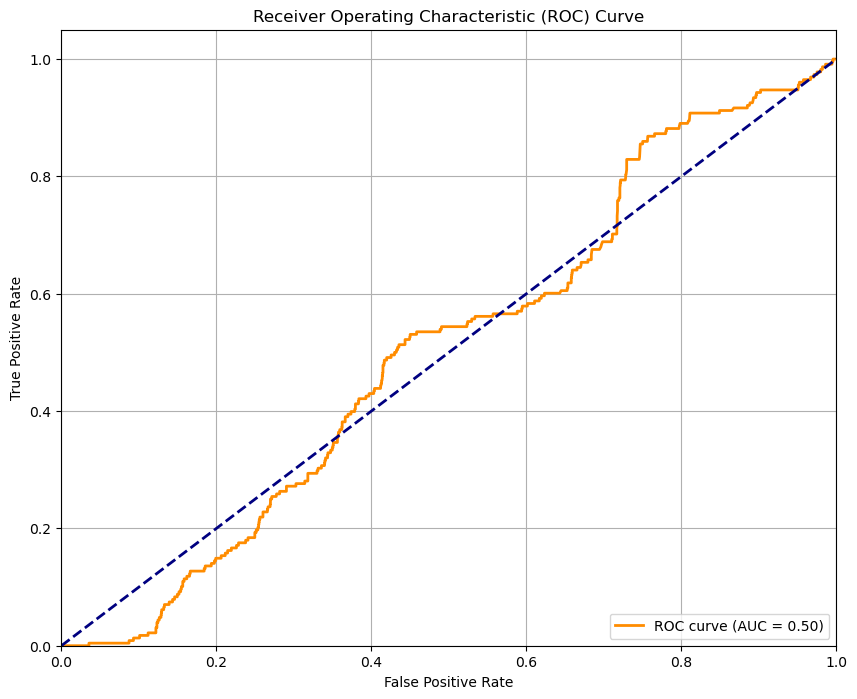

AUC Score: 0.5033

Top 5 recommendations for user MHxPC130442623:
Course ID: MITx/8.MReV/2013_Summer, Score: 0.8125
Course ID: MITx/8.02x/2013_Spring, Score: 0.7776
Course ID: MITx/6.00x/2012_Fall, Score: 0.7210
Course ID: MITx/14.73x/2013_Spring, Score: 0.7186
Course ID: MITx/3.091x/2013_Spring, Score: 0.7108


In [6]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class RecommenderSystem:
    def __init__(self, factors=100, regularization=0.01, iterations=15, 
                 alpha=40, random_state=42):
        """
        Initialize the recommender system
        
        Parameters:
        -----------
        factors : int
            The number of latent factors to compute
        regularization : float
            The regularization factor to use
        iterations : int
            Number of iterations to run
        alpha : float
            The alpha parameter for implicit ratings
        random_state : int
            Random seed for reproducibility
        """
        self.factors = factors
        self.regularization = regularization
        self.iterations = iterations
        self.alpha = alpha
        self.random_state = random_state
        self.model = None
        
    def prepare_data(self, data, user_col='userid_DI', item_col='course_id', 
                    rating_col='nevents_imputed'):
        """
        Prepare the data for training
        
        Parameters:
        -----------
        data : pandas DataFrame
            The input data containing user-item interactions
        """
        # Create user and item mappings
        self.user_ids = data[user_col].unique()
        self.item_ids = data[item_col].unique()
        
        self.user_mapping = {user_id: idx for idx, user_id in enumerate(self.user_ids)}
        self.item_mapping = {item_id: idx for idx, item_id in enumerate(self.item_ids)}
        
        # Reverse mappings for later use
        self.reverse_user_mapping = {v: k for k, v in self.user_mapping.items()}
        self.reverse_item_mapping = {v: k for k, v in self.item_mapping.items()}
        
        # Create mapped indices
        data['user_index'] = data[user_col].map(self.user_mapping)
        data['item_index'] = data[item_col].map(self.item_mapping)
        
        return data
    
    def create_sparse_matrix(self, data, shape=None):
        """
        Create a sparse matrix from the data
        """
        if shape is None:
            shape = (len(self.user_ids), len(self.item_ids))
            
        # Create the sparse matrix
        matrix = coo_matrix(
            (data['nevents_imputed'].values, 
             (data['user_index'].values, data['item_index'].values)),
            shape=shape
        ).tocsr()
        
        # Apply confidence weighting
        matrix = (matrix * self.alpha).astype(np.float32)
        
        return matrix
    
    def train_test_split(self, data, test_size=0.2):
        """
        Split the data into training and testing sets while handling the cold-start problem
        """
        # Group by user to ensure each user has items in both train and test
        user_groups = data.groupby('user_index')
        
        train_data = []
        test_data = []
        
        for _, group in user_groups:
            # For each user, split their interactions
            if len(group) > 1:  # Only split if user has more than one interaction
                user_train, user_test = train_test_split(
                    group, test_size=test_size, random_state=self.random_state
                )
                train_data.append(user_train)
                test_data.append(user_test)
            else:
                # If user has only one interaction, put it in training
                train_data.append(group)
        
        train_data = pd.concat(train_data)
        test_data = pd.concat(test_data) if test_data else pd.DataFrame()
        
        return train_data, test_data
    
    def fit(self, train_matrix):
        """
        Train the model
        """
        self.model = AlternatingLeastSquares(
            factors=self.factors,
            regularization=self.regularization,
            iterations=self.iterations,
            random_state=self.random_state
        )
        
        self.model.fit(train_matrix)
    
    def recommend(self, user_id, n=10, filter_already_liked_items=True):
        """
        Get recommendations for a user
        """
        if user_id not in self.user_mapping:
            return []
        
        user_idx = self.user_mapping[user_id]
        
        # Get recommendations
        recommended = self.model.recommend(
            user_idx,
            self.train_matrix[user_idx],
            N=n,
            filter_already_liked_items=filter_already_liked_items
        )
        
        # Convert back to original IDs and include scores
        recommendations = [
            (self.reverse_item_mapping[item_idx], score)
            for item_idx, score in zip(recommended[0], recommended[1])
        ]
        
        return recommendations
    
    def evaluate(self, test_matrix, k=10):
        """
        Evaluate the model using various metrics
        """
        # Initialize metric trackers
        precision_at_k = []
        recall_at_k = []
        ndcg_at_k = []
        
        # For each user in test set
        for user_idx in tqdm(range(test_matrix.shape[0])):
            # Get actual items for this user in test set
            actual_items = set(test_matrix[user_idx].indices)
            
            if len(actual_items) == 0:
                continue
                
            # Get recommended items
            recommended = self.model.recommend(
                user_idx,
                self.train_matrix[user_idx],
                N=k,
                filter_already_liked_items=True
            )
            recommended_items = set(recommended[0])
            
            # Calculate metrics
            # Precision@K
            precision = len(actual_items & recommended_items) / k
            precision_at_k.append(precision)
            
            # Recall@K
            recall = len(actual_items & recommended_items) / len(actual_items)
            recall_at_k.append(recall)
            
            # NDCG@K
            dcg = 0
            idcg = 0
            for i, item_idx in enumerate(recommended[0]):
                if item_idx in actual_items:
                    dcg += 1 / np.log2(i + 2)
            for i in range(min(len(actual_items), k)):
                idcg += 1 / np.log2(i + 2)
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcg_at_k.append(ndcg)
        
        return {
            f'precision@{k}': np.mean(precision_at_k),
            f'recall@{k}': np.mean(recall_at_k),
            f'ndcg@{k}': np.mean(ndcg_at_k)
        }

    def plot_roc_curve(self, test_matrix):
        """
        Plot ROC curve for the recommender system
        
        Parameters:
        -----------
        test_matrix : scipy.sparse.csr_matrix
            The test set matrix
            
        Returns:
        --------
        float
            The AUC score
        """
        y_true = []
        y_scores = []
        
        print("\nGenerating ROC curve...")
        # Sample a subset of users for efficiency
        n_users = min(1000, test_matrix.shape[0])
        user_indices = np.random.choice(test_matrix.shape[0], n_users, replace=False)
        
        for user_idx in tqdm(user_indices):
            # Get actual items for this user in test set
            actual_items = set(test_matrix[user_idx].indices)
            
            if len(actual_items) == 0:
                continue
            
            # Get recommendations scores for all items
            user_factors = self.model.user_factors[user_idx]
            scores = user_factors.dot(self.model.item_factors.T)
            
            # Sample negative items (items not in test set)
            all_items = set(range(test_matrix.shape[1]))
            negative_items = list(all_items - actual_items)
            sampled_negative = np.random.choice(
                negative_items, 
                min(len(actual_items) * 10, len(negative_items)), 
                replace=False
            )
            
            # Add positive examples
            for item_idx in actual_items:
                y_true.append(1)
                y_scores.append(scores[item_idx])
            
            # Add negative examples
            for item_idx in sampled_negative:
                y_true.append(0)
                y_scores.append(scores[item_idx])

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        return roc_auc

# Usage Example:
if __name__ == "__main__":
    # Load your data
    data = pd.read_csv('cleaned_dataset.csv')
    
    # Initialize recommender system
    recommender = RecommenderSystem(
        factors=100,
        regularization=0.01,
        iterations=15,
        alpha=40
    )
    
    # Prepare data
    data = recommender.prepare_data(data)
    
    # Split into train and test sets
    train_data, test_data = recommender.train_test_split(data, test_size=0.2)
    
    # Create sparse matrices
    recommender.train_matrix = recommender.create_sparse_matrix(train_data)
    test_matrix = recommender.create_sparse_matrix(test_data)
    
    # Train the model
    print("Training the model...")
    start_time = time.time()
    recommender.fit(recommender.train_matrix)
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    
    # Evaluate the model
    print("\nEvaluating the model...")
    metrics = recommender.evaluate(test_matrix, k=10)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Calculate and plot ROC curve
    print("\nCalculating ROC curve...")
    auc_score = recommender.plot_roc_curve(test_matrix)
    print(f"AUC Score: {auc_score:.4f}")
    
    # Example recommendations for a specific user
    example_user = data['userid_DI'].iloc[0]
    print(f"\nTop 5 recommendations for user {example_user}:")
    recommendations = recommender.recommend(example_user, n=5)
    for item_id, score in recommendations:
        print(f"Course ID: {item_id}, Score: {score:.4f}")
